# Data Transfer

### This notebook has information regarding the data transfer per latitude in 12 day chunks run for 60 days

In [1]:
from lusee.observation import LObservation
from lusee.lunar_satellite import LSatellite, ObservedSatellite
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import time
import pickle

## The demodulation function below follows the formula from the excel sheet. Each variable closely matches the varibles from excel sheet

In [2]:
def demodulation(dis_range, rate_pw2, extra_ant_gain):
    R = np.array([430,1499.99,1500,1999.99,2000,2999.99,3000,4499.99,4500,7499.99,7500,10000])
    Pt_error = np.array([11.00,11.00,8.50,8.50,6.00,6.00,4.00,4.00,3.00,3.00,2.50,2.50])
    Antenna_gain = np.arange(11)
    SANT = np.array([21.8,21.8,21.6,21.2,20.6,19.9,18.9,17.7,16.4,14.6,12.6])
    
    Srange_max = 8887.0   #Slant Range
    Srange_min = 2162.0
    Srange_mean = 6297.0

    Freq_MHz = 2250.0
    Asset_EIRP = 13.0 + extra_ant_gain#dBW

    Srange = dis_range

    free_space_path_loss = -20*np.log10(4*np.pi*Freq_MHz*1000000*Srange*1000/300000000)

    R_interp = np.linspace(430,10000,1000)
    Pt_error_intp = interp1d(R,Pt_error)

    Off_pt_angle = 0
    Pt_error_main = Pt_error_intp(Srange)

    Antenna_gain_intp = np.linspace(0,10,1000)
    SANT_intp = interp1d(Antenna_gain,SANT,fill_value="extrapolate")
    #print(Off_pt_angle + Pt_error_main)
    SANT_main = SANT_intp(Off_pt_angle+Pt_error_main)

    Antenna_return_loss = 15
    Mismatch_loss = 10*np.log10(1-(10**(-Antenna_return_loss/20))**2)

    SC_noise_temp = 26.8
    SCGT = SANT_main + Mismatch_loss - SC_noise_temp

    Uplink_CN0 = Asset_EIRP + free_space_path_loss + SCGT - 10*np.log10(1.38e-23)

    Mod_loss = 0.0  #says calculated but given
    Implementation_loss = -1.0  #assumed
    Pll_bw_Hz = 700 #assumed
    Pll_bw_dB = 10*np.log10(Pll_bw_Hz)
    SN_loop = 17.9470058901322

    Carrier_margin = Uplink_CN0 + Implementation_loss - Pll_bw_dB - SN_loop

    Coded_symb_rt_input = rate_pw2
    Coded_symb_rt = 2**Coded_symb_rt_input

    Code_rate = 0.662430862918876   #theory
    Data_rate = Coded_symb_rt * Code_rate

    EbN0 = Uplink_CN0 + Implementation_loss - 10*np.log10(Data_rate*1000)

    Threshold_EbN0 = 2.1
    Data_demod_margin = EbN0 - Threshold_EbN0
    
    return Data_demod_margin, Data_rate

### The below function and the curve_fit is written to calculate the antenna gain that is added to EIRP from above function

In [3]:
def ext_gain_func(x,a,b,c):    
    return a*x**2 + b*x + c

In [4]:
# this is braindead way of doing it, but ok
# from 
ant_gain = [6.5,4.5,0]
ant_angle = [90,60,30] 
popt,pcov = curve_fit(ext_gain_func,ant_angle,ant_gain)
ext_gain = lambda angle : ext_gain_func(angle,*popt)
[ext_gain(x) for x in ant_angle]
    

/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[6.499999999999998, 4.499999999999998, -8.881784197001252e-16]

In [5]:
def get_rate (distance_km, alt_deg, demod_marg = 3):
    extra_gain = ext_gain(alt_deg)
    pw2 = 5
    while True:
        try_demod, try_rate = demodulation(distance_km,pw2,extra_gain)
        if (try_demod < demod_marg) or (pw2==12): 
            break
        pw2+=1
        rate = try_rate
        demod = try_demod
    return rate, demod, (2**(pw2-1))

In [6]:
d_ang = 2
d_dist = 50
ang_l = np.arange(30,91,d_ang)
dist_l = np.arange(1000,9500,d_dist)
rate_arr = np.array([[get_rate(d_,a_) for d_ in dist_l] for a_ in ang_l])

Text(0.5, 1.0, 'link data rate')

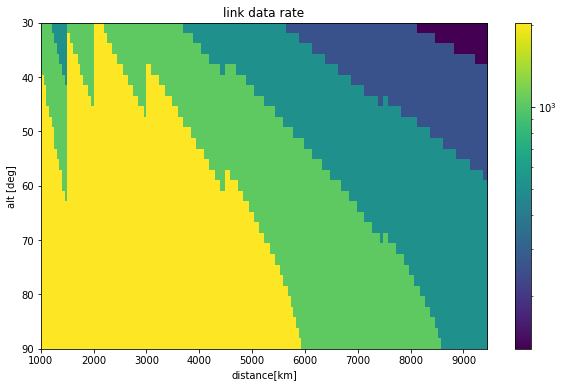

In [7]:
plt.figure(figsize=(10,6))
from matplotlib.colors import LogNorm
plt.imshow(rate_arr[:,:,2],norm=LogNorm(),aspect='auto', interpolation='nearest',extent = [dist_l[0], dist_l[-1], ang_l[-1],ang_l[0]])
plt.colorbar()
plt.xlabel('distance[km]')
plt.ylabel('alt [deg]')
plt.title('link data rate')

In [8]:
def rate_interp (distance_km, alt_deg, ndx = 0):
    i = int((distance_km-dist_l[0])/d_dist)+1 # round up
    j = int((alt_deg-ang_l[0])/d_ang)
    return rate_arr[j,i,ndx]

In [9]:
rate_arr[:,:,2].max(),rate_arr[:,:,2].min()

(2048.0, 128.0)

In [10]:
rate_interp(5000,90)

1356.658407257858

In [11]:
## precalculate all transites and store
use_precomputed = True
cache_fname='transits.pickle'

if use_precomputed:
    deltaT_sec, latitude, transits, alt_deg, az_deg, dist_km = pickle.load(open(cache_fname, 'rb'))
else:
    transits = []
    alt_deg = []
    az_deg = []
    dist_km = []
    latitude = []
    deltaT_sec = 60
    for i in range(13):   # This loop iterates every calculation for 13 latitudes
        print ("Working on ",i+1,"of",13)
        clat = 30+i*(-10)
        obs    = LObservation(lunar_day = "2025-02-01 13:00:00 to 2025-04-01 16:00:00",lun_lat_deg = clat, deltaT_sec=deltaT_sec)
        S       = LSatellite()
        obsat   = ObservedSatellite(obs,S)
        latitude.append(clat)
        transits.append (obsat.get_transit_indices())
        alt_deg.append (obsat.alt_rad() / np.pi*180)
        az_deg.append (obsat.az_rad() / np.pi*180)
        dist_km.append (obsat.dist_km())
    
    pickle.dump([deltaT_sec, latitude, transits, alt_deg, az_deg, dist_km], open(cache_fname, 'wb'))


10
-10
-30


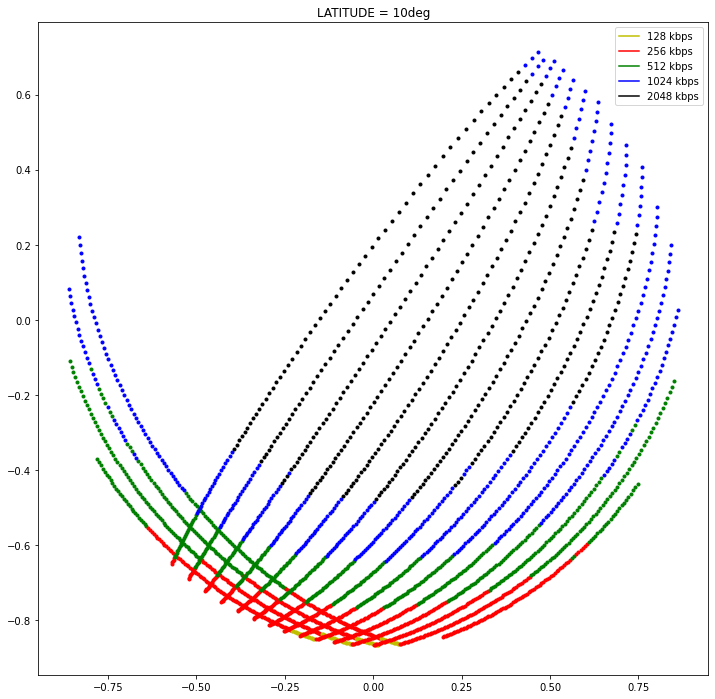

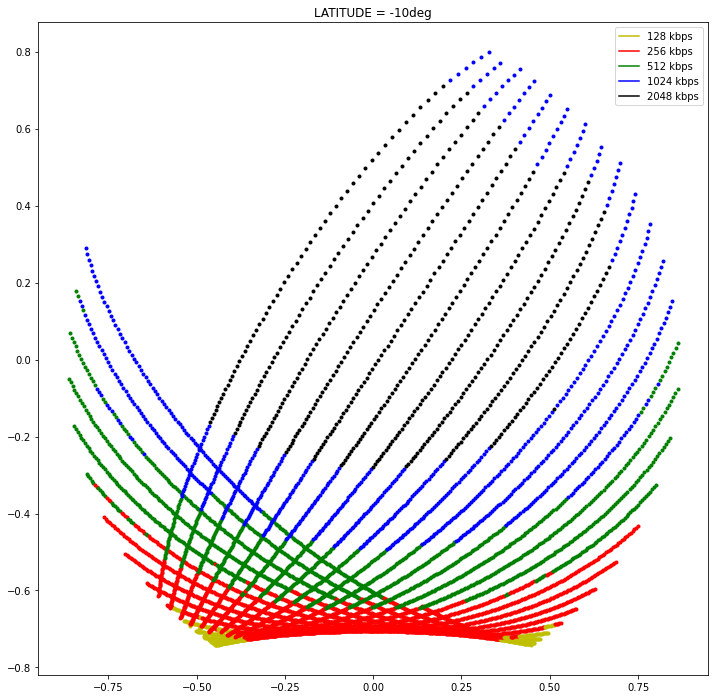

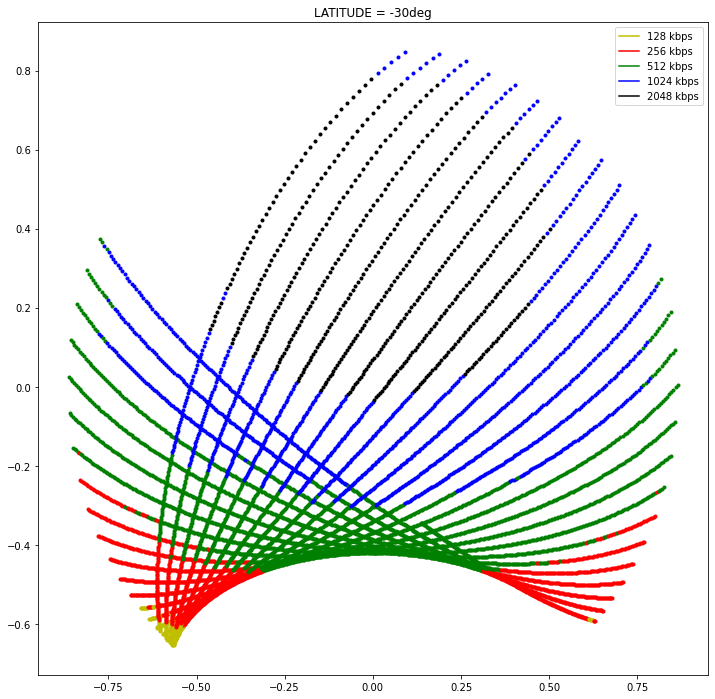

In [12]:
## first plot some transit shape
for lat, trans, alt, az, dist in zip(latitude, transits, alt_deg, az_deg, dist_km):
    if lat not in [10,-10.,-30.]:
        continue
        
    print (lat)
    clrs='yrgbk'
    plt.figure(figsize=(12,12))
    for cc, (ti, tf) in enumerate(trans):
        clr = clrs[cc%len(clrs)]
        if (tf*deltaT_sec/(24*3600)<12):
            for i in range(ti,tf):
                if alt[i]>30:
                    pure = int(np.log(rate_interp(dist[i],alt[i],2))/np.log(2)+1e-3)### for num accuracy

                    r = np.cos(alt[i]/180*np.pi)
                    x,y = r*np.sin(az[i]/180*np.pi), r*np.cos(az[i]/180*np.pi)                    
                    plt.plot([x],[y],'.',color=clrs[pure-7])
                    
                    
    for i,c in enumerate(clrs):
        plt.plot([],[],'-',color=c, label=f'{2**(7+i)} kbps')
    plt.legend()
    plt.title(f'LATITUDE = {lat}deg')

In [13]:
## first plot some transit shape
results = []
for lat, trans, alt, az, dist in zip(latitude, transits, alt_deg, az_deg, dist_km):
    results.append([])
    for dofs in range(49):
        total = 0
        for cc, (ti, tf) in enumerate(trans):
            if (ti*deltaT_sec/(24*3600)>dofs) and (ti*deltaT_sec/(24*3600)<dofs+12):
                for i in range(ti,tf):
                    if alt[i]>30:
                        data_kbps = rate_interp(dist[i],alt[i],0)
                        total += data_kbps*deltaT_sec/(8*1024*1024) # 8 for bits to bytes and 10248**2 from k->G
        results[-1].append(total)
data_total_GB=np.array(results)
data_total_GB.shape

(13, 49)

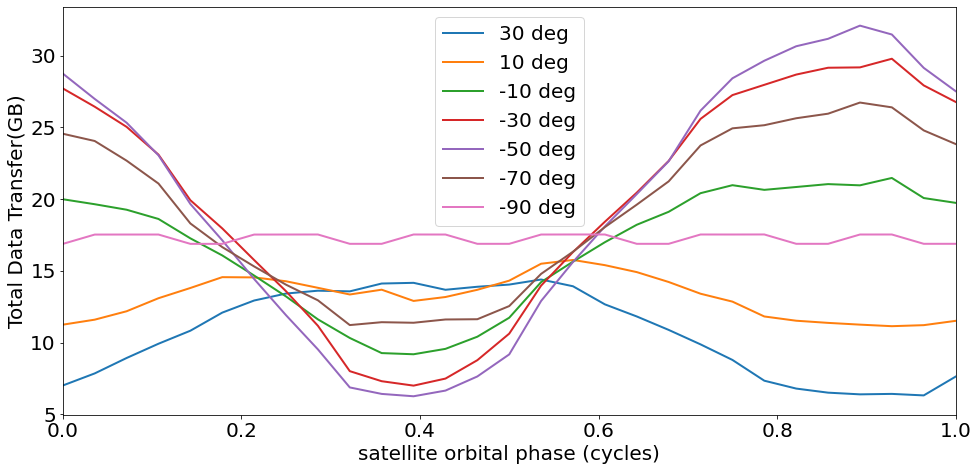

In [37]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(16,7.5))
for data_total, lat in list(zip(data_total_GB,latitude))[::2]:
    fmt = '-'#'--' if lat<-40 else '-'
    plt.plot(np.arange(29)/28.,data_total[:29],fmt,label=f"{lat} deg",lw=2)


plt.xlabel("satellite orbital phase (cycles)") #each number represents 1 12 day chunk
plt.ylabel("Total Data Transfer(GB)")
plt.legend()
plt.xlim(0,1)
plt.show()

fig.savefig("data_tran.pdf",bbox_inches = "tight")

## The below cell plots the histograms of altitude(deg) and Distance(Km) for 13 different latitudes from 30 to -90

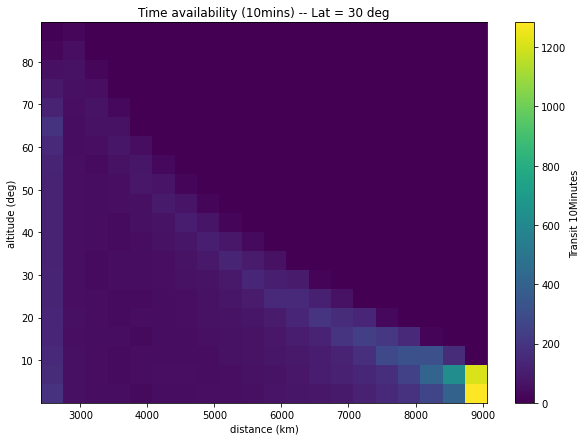

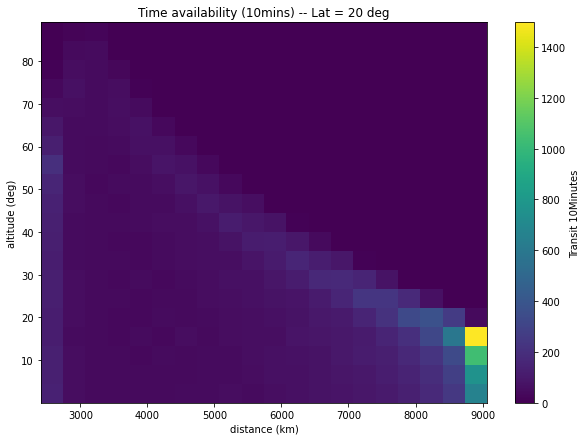

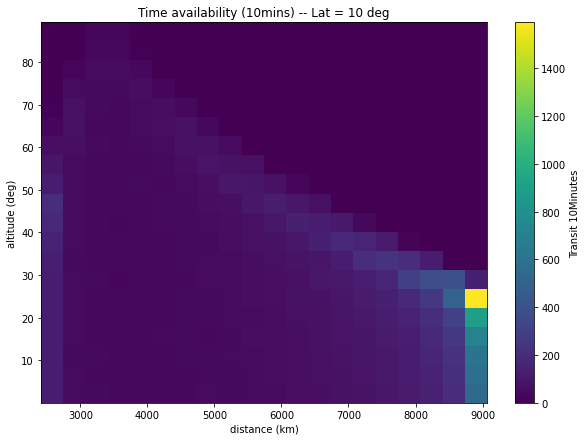

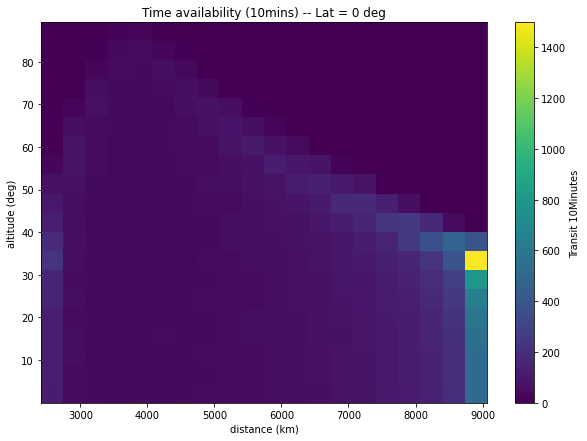

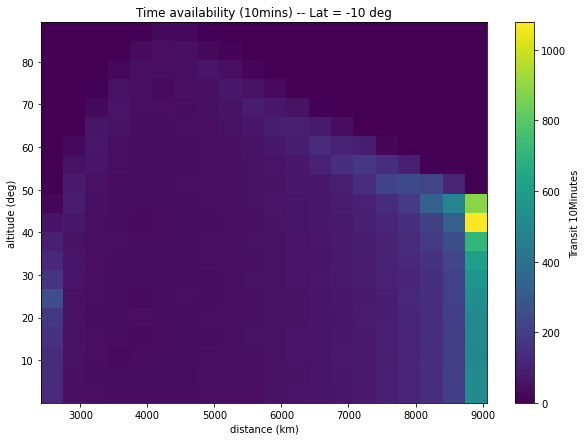

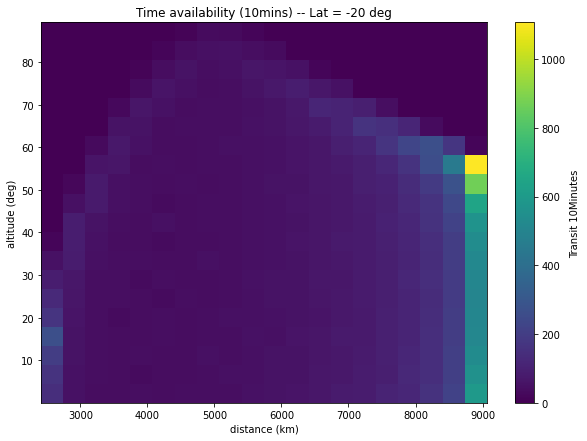

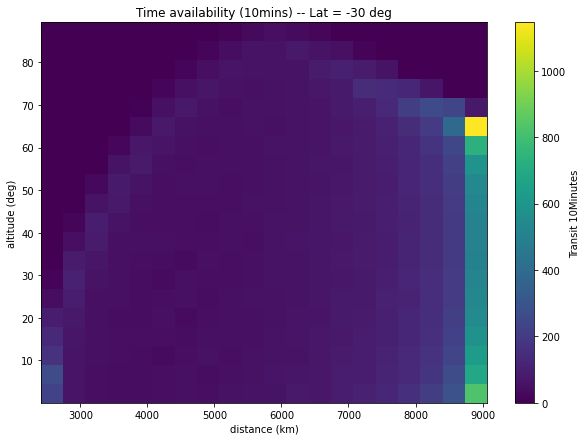

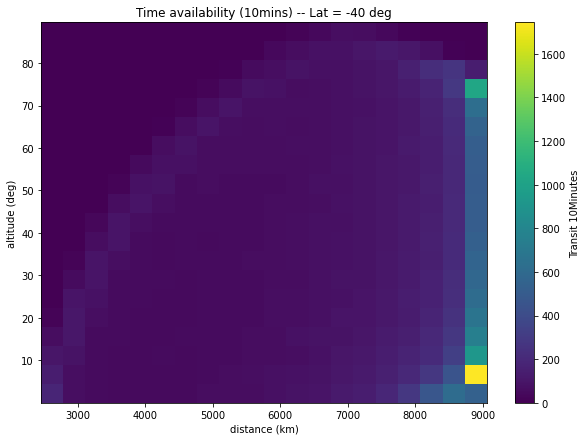

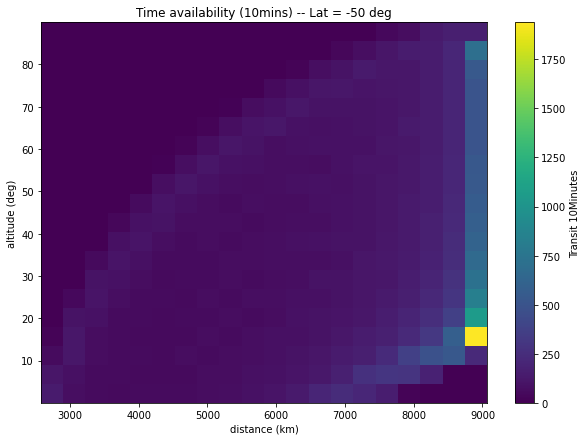

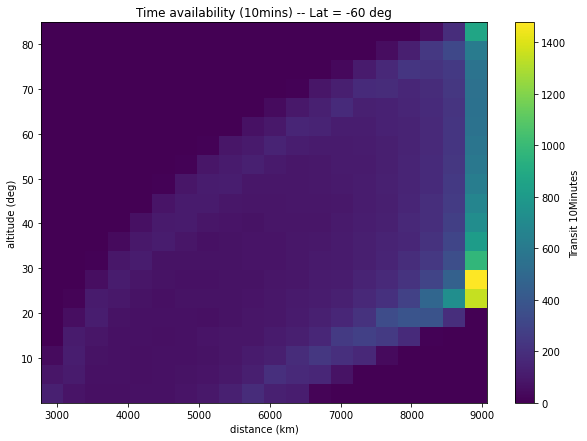

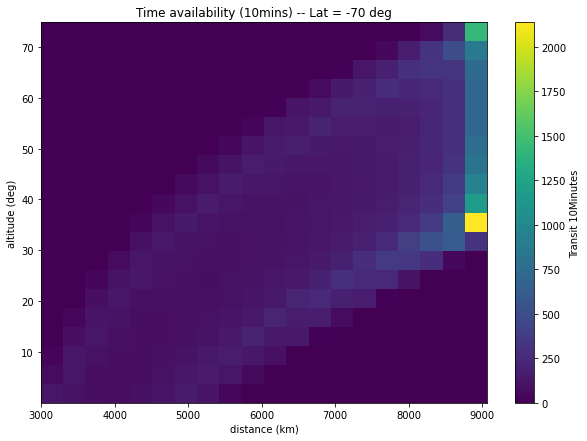

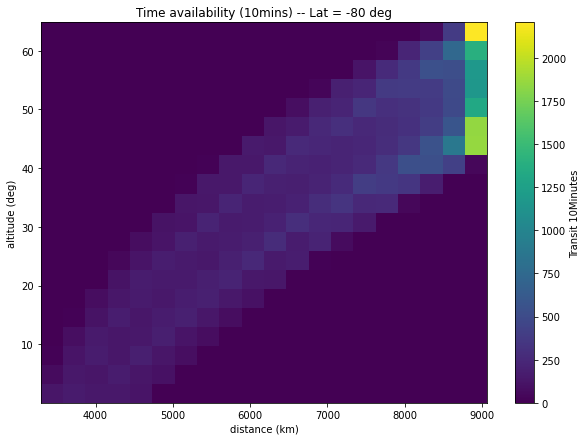

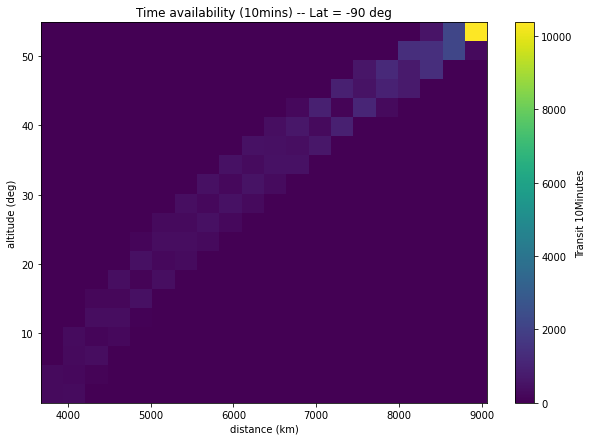

In [19]:
maxi = np.zeros(shape = 13)
mini = np.zeros(shape = 13)
avg = np.zeros(shape = 13)

for i in range(13):
    num = 30+i*(-10)
    obs    = LObservation(lunar_day = "FY2024", lun_lat_deg = num, deltaT_sec=10*60)
    S       = LSatellite()
    obsat   = ObservedSatellite(obs,S)
    transits = obsat.get_transit_indices()
    trans_time = np.array([])
    dist_lun = np.array([])
    alt_lun = np.array([])

    for j in range(len(transits)):
        k,l = transits[j]
        trans_time = np.append(trans_time,l-k)
        dist_lun = np.append(dist_lun,obsat.dist_km()[k:l])
        alt_lun = np.append(alt_lun,obsat.alt_rad()[k:l]/np.pi*180)
    
    maxi[i] = np.max(trans_time)*10/(60)
    mini[i] = np.min(trans_time)*10/(60)
    avg[i] = np.average(trans_time)*10/(60)
    
    fig, axs = plt.subplots(figsize =(10, 7))
 
    type(dist_lun)

    # was not sure on how wide the bins should be
    plt.hist2d(dist_lun, alt_lun,bins = [20,20])  
    plt.title("Time availability (10mins) -- Lat = %i deg" %num)
  
    axs.set_xlabel('distance (km)') 
    axs.set_ylabel('altitude (deg)')

    cbar = plt.colorbar()
    cbar.set_label('Transit 10Minutes')